### Import of the required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from tensorflow import keras

### Load the data

In [3]:
data = pd.read_csv("./data/churn.csv")

## Feature Engineering

### Remove unused columns

In [4]:
data_prepared = data.drop(["RowNumber", "CustomerId", "Surname", "Exited"], axis=1)
y = data["Exited"]

data_prepared

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


### Create pipeline for scalling and one-hot encoding

In [5]:
scaler_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

In [6]:
onehot_pipeline = Pipeline([ 
    ("onehot", OneHotEncoder())
])

In [7]:
full_transformer = ColumnTransformer([
    ("pass", "passthrough", ["HasCrCard", "IsActiveMember"]),
    ("scaler", scaler_pipeline, ["Age", "CreditScore", "Balance", "EstimatedSalary", "Tenure", "NumOfProducts"]),
    ("onehot", onehot_pipeline, ["Geography", "Gender"])
])

### The last 500 records are for the validation set

In [8]:
data_final = data_prepared[:9500]
y_final = y[:9500]
 
data_validation = data_prepared[9500:]
y_validation = y[9500:]

### Splitting the dataset in data and label

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_final, y_final, test_size=0.2, shuffle=True, random_state=42)

### Oversampling the minority class
We need to do an oversampling because the exited class is underrepresented

In [10]:
oversampler = RandomOverSampler(random_state=42, sampling_strategy="auto")
X_train_resample, y_train_resample = oversampler.fit_resample(X_train, y_train)

print(Counter(y_train_resample))
print(X_train_resample.shape)
print(y_train_resample.shape)

Counter({0: 6055, 1: 6055})
(12110, 10)
(12110,)


In [11]:
X_train_onehot_scaled = full_transformer.fit_transform(X_train_resample)
X_test_onehot_scaled = full_transformer.fit_transform(X_test)

print(X_train_onehot_scaled.shape)
print(X_test_onehot_scaled.shape)

(12110, 13)
(1900, 13)


## Train the Neuronal Network

In [12]:
nn_model = keras.models.Sequential([
    keras.layers.Input(shape=X_train_onehot_scaled[-1].shape),
    keras.layers.Dense(64, activation="relu",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(32, activation="relu",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(16, activation="relu",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(8, activation="relu",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1, activation="sigmoid",
                        kernel_regularizer=keras.regularizers.l2(0.01))
])

In [13]:
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss="binary_crossentropy", 
    metrics=["accuracy"])

In [14]:
history = nn_model.fit(X_train_onehot_scaled, y_train_resample, validation_data=(X_test_onehot_scaled, y_test), epochs=15)

Epoch 1/15
379/379 [==============================] - 1s 2ms/step - loss: 1.5284 - accuracy: 0.5666 - val_loss: 1.4216 - val_accuracy: 0.4758
Epoch 2/15
379/379 [==============================] - 1s 2ms/step - loss: 1.2781 - accuracy: 0.6914 - val_loss: 1.2204 - val_accuracy: 0.6163
Epoch 3/15
379/379 [==============================] - 1s 1ms/step - loss: 1.0876 - accuracy: 0.7163 - val_loss: 1.0687 - val_accuracy: 0.6500
Epoch 4/15
379/379 [==============================] - 1s 2ms/step - loss: 0.9530 - accuracy: 0.7266 - val_loss: 0.9551 - val_accuracy: 0.6742
Epoch 5/15
379/379 [==============================] - 1s 2ms/step - loss: 0.8602 - accuracy: 0.7331 - val_loss: 0.8751 - val_accuracy: 0.6884
Epoch 6/15
379/379 [==============================] - 1s 2ms/step - loss: 0.7947 - accuracy: 0.7398 - val_loss: 0.8387 - val_accuracy: 0.6795
Epoch 7/15
379/379 [==============================] - 1s 3ms/step - loss: 0.7474 - accuracy: 0.7466 - val_loss: 0.7901 - val_accuracy: 0.6989
Epoch 

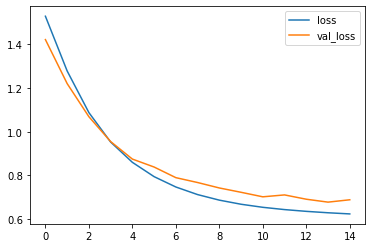

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

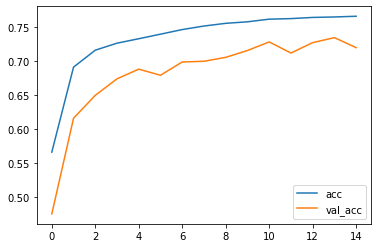

In [16]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()